In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal
import scipy.io
import math
import sys
import time
from IPython.display import HTML, display
from IPython.display import clear_output
 
# #Loading part
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
 
# downloaded = drive.CreateFile({'id': '1N3V-MSFHPms_LTzkQ3qc_Dc1SN59O3K2'})   # replace the id with id of file you want to access
# downloaded.GetContentFile('Protocol1.zip')        # replace the file name with your file


In [ ]:
!pip install keras
!pip install tensorflow-addons
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1N3V-MSFHPms_LTzkQ3qc_Dc1SN59O3K2
!unzip Protocol1
# clear_output()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1N3V-MSFHPms_LTzkQ3qc_Dc1SN59O3K2
To: /content/Protocol1.zip
100% 592M/592M [00:02<00:00, 246MB/s]
Archive:  Protocol1.zip
replace Protocol1/dev/1_1_21_1_001_rgb.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

TensorFlow Version 2.8.2


In [ ]:
image_size = 224
batch_size = 8
n_classes = 2

train_path = '/content/Protocol1/train'
test_path = '/content/Protocol1/test'
dev_path = '/content/Protocol1/dev'

df_train = pd.read_csv('/content/Protocol1/Protocol1_train.csv', dtype = 'str')
df_dev = pd.read_csv('/content/Protocol1/Protocol1_dev.csv', dtype = 'str')

test_images = glob.glob(test_path + '/*.jpg')
df_test = pd.DataFrame(test_images, columns = ['image_path'])

classes = {1 : "True",
           -1 : "Fake"}

In [ ]:
# Data Augmentations

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

valid_gen = datagen.flow_from_dataframe(dataframe = df_dev,
                                        directory = dev_path,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

test_gen = datagen.flow_from_dataframe(dataframe = df_test,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = batch_size,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (image_size, image_size))

Found 10207 validated image filenames belonging to 2 classes.
Found 1805 validated image filenames belonging to 2 classes.
Found 7758 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


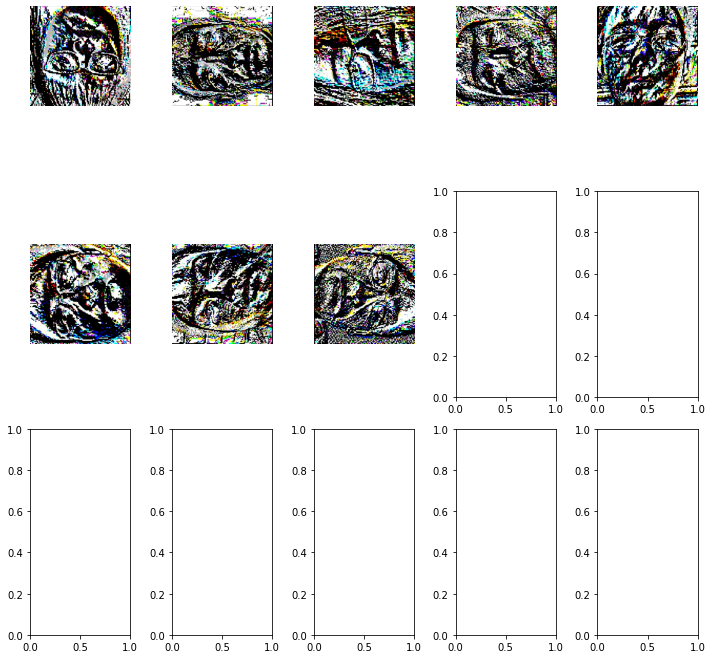

In [ ]:
images = [train_gen[0][0][i] for i in range(8)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
learning_rate = 0.00003
weight_decay = 0.0001
num_epochs = 10

patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


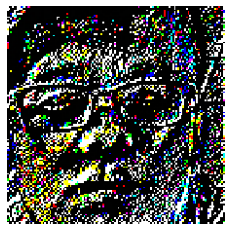

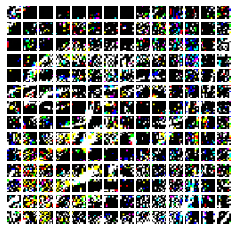

In [ ]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


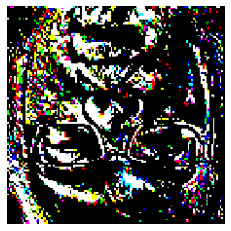

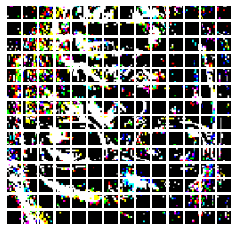

In [ ]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [ ]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, lr_scheduler, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)

Epoch 1/10
1275/1275 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.3885
Epoch 1: val_accuracy improved from -inf to 0.39889, saving model to ./model.hdf5
1275/1275 [==============================] - 178s 131ms/step - loss: 2.6378 - accuracy: 0.3885 - val_loss: 0.7117 - val_accuracy: 0.3989 - lr: 3.0000e-05
Epoch 2/10
1275/1275 [==============================] - ETA: 0s - loss: 1.3954 - accuracy: 0.4231
Epoch 2: val_accuracy improved from 0.39889 to 0.60444, saving model to ./model.hdf5
1275/1275 [==============================] - 164s 129ms/step - loss: 1.3954 - accuracy: 0.4231 - val_loss: 0.6824 - val_accuracy: 0.6044 - lr: 3.0000e-05
Epoch 3/10
1275/1275 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.4768
Epoch 3: val_accuracy improved from 0.60444 to 0.75167, saving model to ./model.hdf5
1275/1275 [==============================] - 164s 128ms/step - loss: 1.1620 - accuracy: 0.4768 - val_loss: 0.6510 - val_accuracy: 0.7517 - lr: 3.0

In [ ]:
print('Training results')
model.evaluate(train_gen)

print('Validation results')
model.evaluate(valid_gen)

Training results
1276/1276 [==============================] - 109s 85ms/step - loss: 0.6381 - accuracy: 0.7754
Validation results
226/226 [==============================] - 19s 84ms/step - loss: 0.6424 - accuracy: 0.7540


[0.6423803567886353, 0.754016637802124]